# Problem Statement: "The Phone App"

You are designing a smart phone app

1. Users can subscribe for a free account identified by their US phone number without extensions. Provide first and last name, date of birth (optional), and sex (optional).
2. Users can add one or more credits cards to their account. Store zipcode, expiration date, and the CVV.
3. The app has paid add-ons called "Track & Field", "Marathon", and "Sprint", each with a fixed price.
4. A user can purchase each add-on, in which case she must provide a credit card for the purchase. Include a purchase date. A user cannot purchase the same addon twice. 

# Design

In [1]:
import datajoint as dj

schema = dj.Schema('app')

[2023-10-31 21:36:21,351][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-10-31 21:36:21,360][INFO]: Connected root@fakeservices.datajoint.io:3306


In [2]:
@schema
class Account(dj.Manual):
    definition = """
    phone : bigint unsigned 
    ---
    first_name : varchar(30)
    last_name : varchar(30)
    dob=null : date
    sex='' : enum('F', 'M', '')
    """


In [3]:
@schema
class CreditCard(dj.Manual):
    definition = """
    card_number :  bigint unsigned 
    ---
    exp_date : date 
    cvv      : smallint unsigned
    zipcode  : int unsigned       
    -> Account
    """

In [4]:
@schema
class AddOn(dj.Lookup):
    definition = """
    addon_id : int
    ---
    addon_name : varchar(30)
    price : decimal(5, 2) unsigned
    """
    contents = ((1, "Track & Field", 13.99), (2, "Marathon", 26.2), (3, "Sprint", 100.00))

In [5]:
AddOn()

addon_id,addon_name,price
1,Track & Field,13.99
2,Marathon,26.20
3,Sprint,100.00


In [6]:
@schema
class Purchase(dj.Manual):
    definition = """
    -> Account
    -> AddOn
    ---
    -> CreditCard
    purchase_date : date 
    """

In [7]:
Purchase()

phone,addon_id,card_number,purchase_date


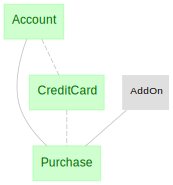

In [8]:
dj.Diagram(schema)

# Populate 
Now we will populate the database with fake data

In [9]:
import random
from tqdm import tqdm
from faker import Faker
fake = Faker()

In [10]:
# insert one account
Account.insert1(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name_male(),
    last_name=fake.last_name(),
    sex="M",
    dob=fake.date_of_birth()))

In [11]:
# insert many male accounts
Account.insert(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name_male(),
    last_name=fake.last_name(),
    sex='M',
    dob=fake.date_of_birth()) for _ in range(5000))

# insert many female accounts
Account.insert(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name_female(),
    last_name=fake.last_name(),
    sex='F',
    dob=fake.date_of_birth()) for _ in range(5000))

# insert some accounts with no sex and no birthdate
Account.insert(dict(
    phone=fake.random_int(1_000_000_0000, 9_999_999_9999),
    first_name=fake.first_name(),
    last_name=fake.last_name()) for _ in range(500))

In [12]:
Account()

phone,first_name,last_name,dob,sex
10022965768,Steven,Mccullough,2015-11-04,M
10028316466,Deborah,Blankenship,1912-07-08,F
10037683725,Debra,Patrick,1976-06-09,F
10052698980,Holly,Gonzalez,1911-10-27,F
10058125916,Diana,Mccoy,2021-08-09,F
10070677966,Sarah,Riley,1969-06-15,F
10082298528,Lisa,Simmons,1941-04-28,F
10090941918,George,Brown,1912-10-06,M
10111873420,Anna,Hall,2021-04-25,F
10119593334,Diana,Woods,1921-05-27,F


In [13]:
# get account ids:
keys = Account.fetch("KEY")

In [14]:
# insert one credit card
CreditCard.insert1(
    dict(random.choice(keys), 
         zipcode=random.randint(10000,99999), 
         card_number=int(fake.credit_card_number()),
         cvv=random.randint(1, 999), 
         exp_date=fake.future_date()))

In [15]:
# insert many credit cards
CreditCard.insert(
    dict(random.choice(keys), 
         zipcode=random.randint(10000,99999), 
         card_number=int(fake.credit_card_number()),
         cvv=random.randint(1, 999), 
         exp_date=fake.future_date()) for _ in range(15000))

In [17]:
# get all possible valid purchases, eliminate duplicate purchases that are under different cards
purchases = (Account * CreditCard * AddOn - Purchase.proj()).fetch("KEY", order_by=('phone', 'addon_id'))
unique_purchases = [purchases.pop()]
for purchase in purchases:
    if (purchase['phone'], purchase['addon_id']) != (unique_purchases[-1]['phone'], unique_purchases[-1]['addon_id']):
        unique_purchases.append(dict(purchase, purchase_date=fake.past_date()))

# insert a random subset 
Purchase.insert(random.sample(unique_purchases, 5000))

In [ ]:
schema.drop()     # optionally drop the schema to clear before the next run